In [2]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

# Pfade zu den CSV-Dateien
train_file = '/mnt/chromeos/MyFiles/Downloads/train.csv'
test_file = '/mnt/chromeos/MyFiles/Downloads/test.csv'
ideal_file = '/mnt/chromeos/MyFiles/Downloads/ideal.csv'

# Lade die CSV-Dateien
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
ideal_df = pd.read_csv(ideal_file)

# Erstelle die SQLite-Datenbank
engine = create_engine('sqlite:///data.db')
conn = engine.connect()

# Speicher die Trainingsdaten in die Datenbank
train_df.to_sql('training_data', conn, if_exists='replace', index=False)

# Speicher die idealen Funktionen in die Datenbank
ideal_df.to_sql('ideal_functions', conn, if_exists='replace', index=False)

# Struktur der Testdaten anpassen und speichern
test_df.columns = ['x', 'y']
test_df.to_sql('test_data', conn, if_exists='replace', index=False)

# Schließe die Verbindung
conn.close()


ModuleNotFoundError: No module named 'sqlalchemy'

In [ ]:
import numpy as np

# Verbinde mit der Datenbank
conn = sqlite3.connect('data.db')

# Lade die Daten
train_df = pd.read_sql('SELECT * FROM training_data', conn)
ideal_df = pd.read_sql('SELECT * FROM ideal_functions', conn)

# Funktion zur Berechnung der Summe der quadratischen Abweichungen
def calculate_least_squares(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

# Wähle die besten idealen Funktionen
best_functions = []
for col in train_df.columns[1:]:
    min_error = float('inf')
    best_function = None
    for ideal_col in ideal_df.columns[1:]:
        error = calculate_least_squares(train_df[col], ideal_df[ideal_col])
        if error < min_error:
            min_error = error
            best_function = ideal_col
    best_functions.append(best_function)

print("Die besten idealen Funktionen sind:", best_functions)

conn.close()

Die besten idealen Funktionen sind: ['y36', 'y11', 'y2', 'y33']


In [ ]:
import pandas as pd
import numpy as np
import sqlite3

# Verbinde mit der Datenbank
conn = sqlite3.connect('data.db')

try:
    # Lade die Testdaten
    test_df = pd.read_sql('SELECT * FROM test_data', conn)

    # Funktion zur Validierung der Testdaten
    def validate_test_data(test_df, ideal_df, best_functions, threshold):
        results = []
        for index, row in test_df.iterrows():
            x = row['x']
            y = row['y']
            for function in best_functions:
                y_ideal = ideal_df[ideal_df['x'] == x][function].values[0]
                delta_y = abs(y - y_ideal)
                if delta_y <= threshold:
                    results.append((x, y, delta_y, function))
        return pd.DataFrame(results, columns=['x', 'y', 'delta_y', 'ideal_function'])

    # Berechne den Threshold
    threshold = np.sqrt(2) * train_df.drop(columns=['x']).max().max()

    # Validierung durchführen
    validation_results = validate_test_data(test_df, ideal_df, best_functions, threshold)

    # Speicher die Ergebnisse in die Datenbank
    validation_results.to_sql('validation_results', conn, if_exists='replace', index=False)

finally:
    conn.close()  # Schließe die Verbindung im finally-Block, damit sie auch bei einem Fehler geschlossen wird

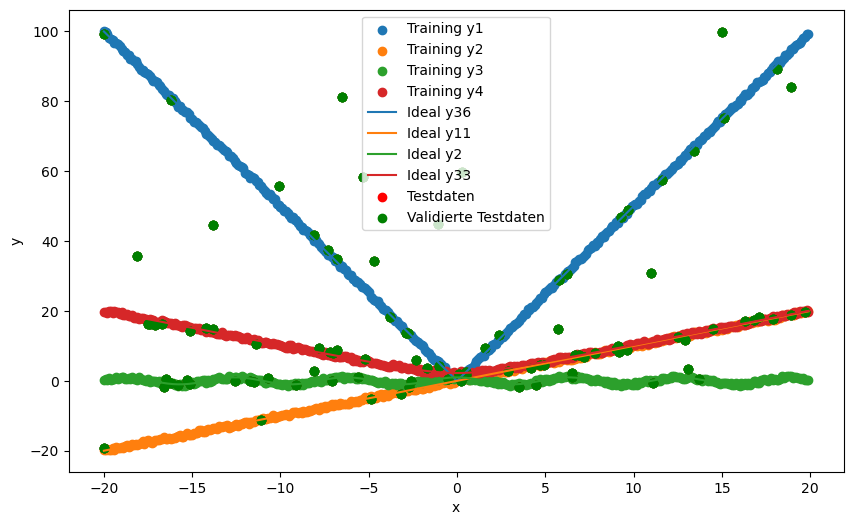

In [ ]:
import matplotlib.pyplot as plt

# Lade die Validierungsergebnisse
conn = sqlite3.connect('data.db')
validation_results = pd.read_sql('SELECT * FROM validation_results', conn)
conn.close()

# Plot der Ergebnisse
plt.figure(figsize=(10, 6))

# Trainingsdaten plotten
for col in train_df.columns[1:]:
    plt.scatter(train_df['x'], train_df[col], label=f'Training {col}')

# Ideale Funktionen plotten
for function in best_functions:
    plt.plot(ideal_df['x'], ideal_df[function], label=f'Ideal {function}')

# Testdaten plotten
plt.scatter(test_df['x'], test_df['y'], label='Testdaten', color='red')

# Validierungsergebnisse plotten
plt.scatter(validation_results['x'], validation_results['y'], label='Validierte Testdaten', color='green')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
# Definition der Funktionen
import numpy as np
import pandas as pd

def calculate_least_squares(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def validate_test_data(test_df, ideal_df, best_functions, threshold):
    results = []
    for index, row in test_df.iterrows():
        x = row['x']
        y = row['y']
        for function in best_functions:
            y_ideal = ideal_df[ideal_df['x'] == x][function].values[0]
            delta_y = abs(y - y_ideal)
            if delta_y <= threshold:
                results.append((x, y, delta_y, function))
    return pd.DataFrame(results, columns=['x', 'y', 'delta_y', 'ideal_function'])

In [ ]:
import unittest
import numpy as np
import pandas as pd

class TestYourFunctions(unittest.TestCase):

    def test_calculate_least_squares(self):
        y_true = np.array([1, 2, 3])
        y_pred = np.array([1, 2, 3])
        result = calculate_least_squares(y_true, y_pred)
        self.assertEqual(result, 0)

        y_pred = np.array([2, 3, 4])
        result = calculate_least_squares(y_true, y_pred)
        self.assertEqual(result, 3)

    def test_validate_test_data(self):
        test_df = pd.DataFrame({'x': [1, 2, 3], 'y': [1, 2, 3]})
        ideal_df = pd.DataFrame({'x': [1, 2, 3], 'ideal_1': [1, 2, 3], 'ideal_2': [2, 3, 4]})
        best_functions = ['ideal_1']
        threshold = 1.5
        result_df = validate_test_data(test_df, ideal_df, best_functions, threshold)
        expected_df = pd.DataFrame({'x': [1, 2, 3], 'y': [1, 2, 3], 'delta_y': [0, 0, 0], 'ideal_function': ['ideal_1', 'ideal_1', 'ideal_1']})
        pd.testing.assert_frame_equal(result_df, expected_df)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


..
----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


In [ ]:
class TestYourFunctions(unittest.TestCase):

    def test_calculate_least_squares(self):
        y_true = np.array([1, 2, 3])
        y_pred = np.array([1, 2, 3])
        result = calculate_least_squares(y_true, y_pred)
        self.assertEqual(result, 0)

        y_pred = np.array([2, 3, 4])
        result = calculate_least_squares(y_true, y_pred)
        self.assertEqual(result, 3)

    def test_calculate_least_squares_negative_values(self):
        y_true = np.array([1, -2, 3])
        y_pred = np.array([1, -3, 4])
        result = calculate_least_squares(y_true, y_pred)
        self.assertEqual(result, 2)

    def test_validate_test_data(self):
        test_df = pd.DataFrame({'x': [1, 2, 3], 'y': [1, 2, 3]})
        ideal_df = pd.DataFrame({'x': [1, 2, 3], 'ideal_1': [1, 2, 3], 'ideal_2': [2, 3, 4]})
        best_functions = ['ideal_1']
        threshold = 1.5
        result_df = validate_test_data(test_df, ideal_df, best_functions, threshold)
        expected_df = pd.DataFrame({'x': [1, 2, 3], 'y': [1, 2, 3], 'delta_y': [0, 0, 0], 'ideal_function': ['ideal_1', 'ideal_1', 'ideal_1']})
        pd.testing.assert_frame_equal(result_df, expected_df)

    def test_validate_test_data_no_matches(self):
        test_df = pd.DataFrame({'x': [1, 2, 3], 'y': [10, 20, 30]})
        ideal_df = pd.DataFrame({'x': [1, 2, 3], 'ideal_1': [1, 2, 3], 'ideal_2': [2, 3, 4]})
        best_functions = ['ideal_1']
        threshold = 1.5
        result_df = validate_test_data(test_df, ideal_df, best_functions, threshold)
        expected_df = pd.DataFrame(columns=['x', 'y', 'delta_y', 'ideal_function'])
        pd.testing.assert_frame_equal(result_df, expected_df)

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.007s

OK
